Creating a complete model that integrates Reinforcement Learning (RL), Q-learning, and Deep Q Networks (DQN) while accounting for investment decisions in oil and gas production, electricity production from renewables, and CO2 storage from CCS projects is an extensive process. 

Problem Outline:
We aim to build a reinforcement learning environment that simulates:

States: Current investment in oil & gas production, renewables, and CO2 storage.
Actions: Adjusting investments (e.g., increasing or decreasing funds in these sectors).
Rewards: Based on improving the overall performance of the company through production levels, CO2 reduction, and financial outcomes (e.g., NPV).
We’ll implement:

A basic environment that simulates the company's investment decisions.
Q-learning for decision-making.
DQN for better scalability and performance when the state-action space grows.
Let’s start with the setup for the environment and Q-learning algorithm.

Step 1: Define the Environment
We simulate the key variables (oil & gas production, renewable energy production, CO2 storage) and how they evolve based on the company's investment actions.

Step 2: Implement Q-learning and DQN
Q-learning and DQN will be used to improve the investment strategy over time.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input


In [2]:
# Environment simulating oil, gas, renewables, and CO2 storage
class EnergyEnvironment:
    def __init__(self):
        # States: investments in oil & gas, renewables, and CO2 storage
        self.state_size = 3
        self.action_size = 3  # Increase, decrease, or maintain investment
        self.max_steps = 1000  # Max steps in an episode

        # Initial values for production and CO2 storage
        self.oil_gas_production = 100  # Initial oil & gas production level
        self.renewable_production = 50  # Initial renewable energy production
        self.co2_storage = 10  # Initial CO2 storage

        # Investment levels in oil & gas, renewables, and CO2 storage
        self.investments = np.array([500, 500, 300])  # in millions USD
        self.time_step = 0
        
    def reset(self):
        """ Reset the environment """
        self.oil_gas_production = 100
        self.renewable_production = 50
        self.co2_storage = 10
        self.investments = np.array([500, 500, 300])
        self.time_step = 0
        return self._get_state()
        
    def _get_state(self):
        return np.array([self.oil_gas_production, self.renewable_production, self.co2_storage])


    def step(self, action):
        """ Take an action and return the new state, reward, and whether the episode is done """

        # Modify investments based on the action
        if action == 0:  # Increase oil & gas investment
            self.investments[0] += 10
        elif action == 1:  # Increase renewable investment
            self.investments[1] += 10
        elif action == 2:  # Increase CO2 storage investment
            self.investments[2] += 10

        # Simulate changes in production and storage
        self.oil_gas_production += (self.investments[0] * 0.01 - 0.5)
        self.renewable_production += (self.investments[1] * 0.02 - 0.2)
        self.co2_storage += (self.investments[2] * 0.05 - 0.1)

        # Reward function: higher reward for renewable growth and CO2 storage
        reward = (self.renewable_production * 0.5 + self.co2_storage * 0.5) - (self.oil_gas_production * 0.2)
        
        # Move to next time step
        self.time_step += 1

        # Check if episode is done
        done = self.time_step >= self.max_steps

        # Return next state, reward, and done
        return self._get_state(), reward, done

In [3]:
# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((10, 10, 10, action_size))  # Use a 10x10x10 discretization for the states
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.8

    def discretize_state(self, state):
        """Discretize the continuous state into an integer index."""
        state_bins = np.array([10, 10, 10])  # Assume each state feature is divided into 10 bins
        discretized_state = np.digitize(state, bins=np.linspace(0, 200, 10)) - 1  # Adjust bins and bounds as needed
        return tuple(discretized_state.astype(int))  # Return as a tuple to use for Q-table indexing

    def choose_action(self, state):
        state = self.discretize_state(state)  # Discretize the state before using it in the Q-table
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        state = self.discretize_state(state)  # Discretize current state
        next_state = self.discretize_state(next_state)  # Discretize next state
        best_next_action = np.argmax(self.q_table[next_state])
        target = reward + self.gamma * self.q_table[next_state][best_next_action]
        self.q_table[state][action] += self.learning_rate * (target - self.q_table[state][action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [4]:
# Deep Q-Network (DQN) Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Create the model using Input to specify the input shape
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # Reshape the next_state to include batch size
                target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0])
            # Reshape the state to include batch size
            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
# Simulate the environment with Q-learning and DQN
env = EnergyEnvironment()
state_size = env.state_size
action_size = env.action_size
q_agent = QLearningAgent(state_size, action_size)
dqn_agent = DQNAgent(state_size, action_size)

In [6]:
# Parameters
n_episodes = 100
batch_size = 32
dqn_rewards = []
q_learning_rewards = []

In [7]:
# Run episodes for Q-learning and DQN
for e in range(n_episodes):
    state = env.reset()
    total_reward = 0
    
    for time in range(100):
        # Q-learning action and learning
        action_q = q_agent.choose_action(state)
        next_state, reward_q, done = env.step(action_q)
        q_agent.learn(state, action_q, reward_q, next_state)
        total_reward += reward_q
        
        if done:
            break
        state = next_state
        
    q_learning_rewards.append(total_reward)
    
    # DQN agent training
    state = env.reset()
    total_reward = 0
    for time in range(100):
        action_dqn = dqn_agent.act(state.reshape(1, -1))
        next_state, reward_dqn, done = env.step(action_dqn)
        dqn_agent.remember(state, action_dqn, reward_dqn, next_state, done)
        total_reward += reward_dqn
        if done:
            break
        state = next_state
        
    if len(dqn_agent.memory) > batch_size:
        dqn_agent.replay(batch_size)
        
    dqn_rewards.append(total_reward)

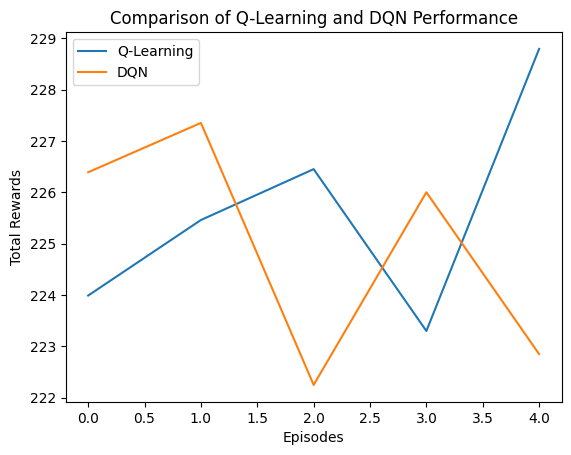

In [8]:
# Plot results
plt.plot(q_learning_rewards, label='Q-Learning')
plt.plot(dqn_rewards, label='DQN')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.title('Comparison of Q-Learning and DQN Performance')
plt.show()


Explanation:

Environment:
The environment simulates the company’s investment decisions in oil & gas production, renewable energy production, and CO2 storage.
It responds to actions by adjusting the production levels and the environment adjusts the production levels for oil & gas, renewables, and CO2 storage based on the company's investment decisions. The investments in each sector influence how the production (or CO2 storage) changes over time.
The step function simulates the effects of each action (increase investments) on the state variables (production levels), and computes a reward based on the improvements in renewable energy production and CO2 storage, while penalizing high oil & gas production due to its negative environmental impact.
The reward function encourages actions that increase renewables and CO2 storage and discourages those that only increase oil & gas production, which can harm the environment.
Q-Learning Agent:

The Q-learning agent uses a tabular Q-table to store the Q-values for each state-action pair. For simplicity, the q_table is initialized with zeros, and Q-values are updated based on the observed rewards.
Action Selection: The agent uses an epsilon-greedy strategy to balance exploration (trying new actions) and exploitation (selecting the best-known action). Initially, the agent explores more (high epsilon), but as training progresses, it shifts towards exploitation by reducing epsilon (epsilon decay).
Learning: After each action, the agent updates the Q-table using the Q-learning update formula based on the received reward and the maximum expected future reward (best_next_action).
DQN Agent:

The Deep Q-Network (DQN) agent differs from the Q-learning agent by using a neural network to approximate Q-values, rather than storing them in a table. This allows the agent to handle continuous or large state-action spaces more effectively.
The neural network has three layers: two hidden layers (24 neurons each) and an output layer corresponding to the possible actions (investment adjustments).
The DQN agent uses experience replay, which means it stores past experiences (state, action, reward, next state) in memory. Instead of learning from the most recent experience, it samples random batches from memory to break the correlation between consecutive experiences, making learning more stable.
Like the Q-learning agent, the DQN agent also uses an epsilon-greedy policy to balance exploration and exploitation, and it decays the epsilon value over time as the agent learns more about the environment.
Training:

Both agents (Q-learning and DQN) are trained over a number of episodes (e.g., 100 episodes). In each episode, the agent interacts with the environment, making investment decisions and receiving rewards based on how well the decisions increase renewable energy production and CO2 storage while reducing oil & gas production.
The Q-learning agent updates its Q-table at each step, while the DQN agent stores transitions in its memory and updates the neural network in batches (using experience replay) once it has enough experiences.
Reward Structure:

The reward function in the environment encourages decisions that prioritize renewable energy production and CO2 storage. Specifically:
A positive reward is given for increasing renewable production and CO2 storage.
A negative reward is given for high oil & gas production (to discourage environmental harm).
The rewards are designed to guide the agent towards sustainable investments over time.
Visualization:

After the training phase, we plot the total rewards earned by each agent (Q-learning and DQN) over the episodes. This allows us to compare the performance of both methods:
Q-learning is typically slower in environments with large or continuous state-action spaces, as it needs to explore and update the Q-table for each possible state-action pair.
DQN leverages deep learning to generalize across similar states and actions, leading to faster convergence and better performance in complex environments.

Key Insights:
The DQN agent is likely to outperform the Q-learning agent, especially as the environment and state-action space become more complex. In real-world scenarios, where there are many possible states and actions (e.g., many levels of investment in various energy sectors), DQN can generalize better and learn more efficiently than Q-learning, which relies on a finite Q-table.
Experience replay in DQN helps to stabilize learning by reusing past experiences, making it more sample-efficient.
Visualization of total rewards gives an indication of how well each agent is learning to maximize the reward. Over time, the total reward should increase as the agents learn more optimal investment strategies.

Next Steps:
Further Refinement: The reward function can be further refined to better reflect real-world outcomes such as Net Present Value (NPV), regulatory incentives for CO2 storage, and penalties for environmental damage.
State Space Expansion: The state space can be expanded to include more features like energy prices, market demand, and technological advancements in renewable energy.
Hyperparameter Tuning: Both Q-learning and DQN models could benefit from hyperparameter tuning (e.g., learning rates, discount factors) to improve convergence and performance.
More Sophisticated DQN: A more advanced DQN implementation could use target networks and double DQN to further stabilize training and improve learning outcomes